In [3]:
import numpy as np
import pandas as pd
import torch
from torch import nn

import Util
import tsGAN
#%run -i 'tsGAN.py'

import os

import matplotlib.pyplot as plt

import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
sns.set_style('white')
sns.set_context('poster')

In [5]:
# CSV path
folder_name = "data"
file_name = "hungary_chickenpox.csv"
path = os.path.join(folder_name, file_name)
#Load CSV into Dataframe
df = pd.read_csv(path,sep=',')
df = df.drop(columns = ['Date'])

In [6]:
# Get column names
names = Util.get_column_names(df)

In [7]:
#Showing the different counties in Hungary
df.keys()

Index(['BUDAPEST', 'BARANYA', 'BACS', 'BEKES', 'BORSOD', 'CSONGRAD', 'FEJER',
       'GYOR', 'HAJDU', 'HEVES', 'JASZ', 'KOMAROM', 'NOGRAD', 'PEST', 'SOMOGY',
       'SZABOLCS', 'TOLNA', 'VAS', 'VESZPREM', 'ZALA'],
      dtype='object')

In [8]:
# fig, axes = plt.subplots(1,3,figsize=(20,5))

# sns.lineplot(data=df,x=df.index,y='BUDAPEST',ax=axes[0])
# axes[0].set_xticks(np.arange(0,550,100))
# axes[0].set_xlabel('Weeks')
# axes[0].set_ylabel('Chicken Pox Cases')
# axes[0].set_title('BUDAPEST')

# sns.lineplot(data=df,x=df.index,y='PEST',ax=axes[1])
# axes[1].set_xticks(np.arange(0,550,100))
# axes[1].set_xlabel('Weeks')
# axes[1].set_ylabel('Chicken Pox Cases')
# axes[1].set_title('PEST')

# sns.lineplot(data=df,x=df.index,y='BORSOD',ax=axes[2])
# axes[2].set_xticks(np.arange(0,550,100))
# axes[2].set_xlabel('Weeks')
# axes[2].set_ylabel('Chicken Pox Cases')
# axes[2].set_title('BORSOD');

In [9]:
# Set random state
torch.manual_seed(111)
# Select # of data points from data set to train GAN
num_data = 522

# Specify dimensionality of dataframe
df_dim = len(df.columns)
# learning rate
lr = 0.005
# number of epoch
num_epochs = 500
# Discriminator and Generator dropout for data standardization
drop_out=0.2
# Define batch size for the data loader
batch_size = 18


# These create the arrays and then turns them into tensors for the train loader 
arrays = Util.create_arrays(df[:num_data],num_data)
train_set = Util.create_tensors(arrays)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)

In [10]:
#Calling the generator and discriminator
generator = tsGAN.Generator(df_dim,batch_size,drop_out)
discriminator =  tsGAN.Discriminator(df_dim,batch_size,drop_out)

In [11]:
#Training the generator and discriminator with the data and returning a list of the losses
dim_list, gen_list = tsGAN.training_loop(generator, discriminator, num_epochs, train_loader, batch_size,lr,df_dim)

Epoch: 0 Loss D.: 0.22110597789287567
Epoch: 0 Loss G.: 1.0757458209991455
Epoch: 10 Loss D.: 0.16622205078601837
Epoch: 10 Loss G.: 1.3103718757629395
Epoch: 20 Loss D.: 0.04556063935160637
Epoch: 20 Loss G.: 2.8912320137023926
Epoch: 30 Loss D.: 0.21811021864414215
Epoch: 30 Loss G.: 2.7058467864990234
Epoch: 40 Loss D.: 0.37349286675453186
Epoch: 40 Loss G.: 2.6572041511535645
Epoch: 50 Loss D.: 0.4365483224391937
Epoch: 50 Loss G.: 2.0462934970855713
Epoch: 60 Loss D.: 0.5024272799491882
Epoch: 60 Loss G.: 2.2880258560180664
Epoch: 70 Loss D.: 0.5468729734420776
Epoch: 70 Loss G.: 2.175541877746582
Epoch: 80 Loss D.: 0.6257530450820923
Epoch: 80 Loss G.: 1.7021538019180298
Epoch: 90 Loss D.: 0.6365706324577332
Epoch: 90 Loss G.: 1.4881088733673096
Epoch: 100 Loss D.: 0.5502976179122925
Epoch: 100 Loss G.: 1.4854164123535156
Epoch: 110 Loss D.: 0.2464890480041504
Epoch: 110 Loss G.: 1.2659659385681152
Epoch: 120 Loss D.: 3.685094118118286
Epoch: 120 Loss G.: 0.9995021820068359
Epoch

In [12]:
#Converting the losses from tensors into a DataFrame

#Initializing the loss lists
dim_list_new = []
gen_list_new = []

#Iterating through the lists of tensors and converting them to arrays
for i in np.arange(0,len(dim_list)):
    d = dim_list[i].detach().numpy()
    g = gen_list[i].detach().numpy()
    dim_list_new.append(d)
    gen_list_new.append(g)

#Putting these loss lists into Dataframes
dim_list_new=pd.DataFrame(dim_list_new, columns=['dim_loss'])
gen_list_new=pd.DataFrame(gen_list_new, columns=['gen_loss'])

loss = pd.concat([dim_list_new,gen_list_new],axis=1)


In [13]:
len(loss)

14500

Text(0.5, 0, 'Step')

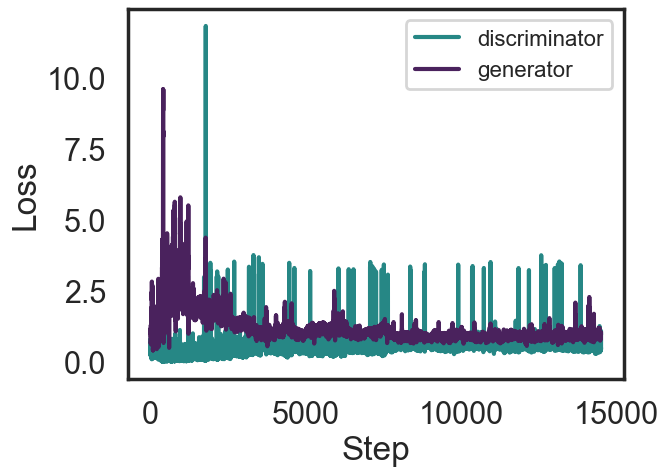

In [14]:
#Plotting the losses of the discriminator and the generator
fig, ax = plt.subplots()

sns.lineplot(data=loss, x=range(0, len(loss)),y='dim_loss',sort=False, label = 'discriminator',color='#268785')
sns.lineplot(data=loss, x=range(0, len(loss)),y='gen_loss',sort=False, label = 'generator',color='#4A225D')

ax.legend(fontsize = 16)
ax.set_ylabel('Loss')
ax.set_xlabel('Step')
#ax.set_ylim(-0.7,1)

In [15]:
# After training the Gen, generates data as tensors
latent_space_samples = torch.randn((num_data), df_dim)
generated_samples = generator(latent_space_samples)
generated_samples = generated_samples.detach()

In [16]:
# Takes the generated data and turns it into a pandas DataFrame
df_gen=pd.DataFrame(generated_samples, columns=names)
df_gen

,BUDAPEST,BARANYA,BACS,BEKES,BORSOD,CSONGRAD,FEJER,GYOR,HAJDU,HEVES,JASZ,KOMAROM,NOGRAD,PEST,SOMOGY,SZABOLCS,TOLNA,VAS,VESZPREM,ZALA
0,27.976746,69.483627,6.844683,27.258961,56.196621,24.111208,8.243703,77.968102,114.888390,0.021249,81.394440,8.396393,17.480526,178.613144,65.821716,30.565889,48.688175,5.703436,53.788197,42.865494
1,-3.744143,15.230401,25.058687,8.711142,20.116230,13.750083,6.185132,7.957179,11.031759,25.223364,53.286388,5.132269,5.440668,6.386628,23.645283,-7.806082,1.653093,46.224300,26.043690,25.277554
2,36.238239,35.383102,35.542530,13.049688,5.061095,0.967135,21.370905,26.951088,8.706701,12.846345,58.952065,26.750422,6.827087,45.421768,36.384628,3.919689,7.575204,36.196674,24.428125,9.171684
3,196.027802,19.864887,56.815620,4.399106,94.123688,77.311714,60.698284,11.314784,50.068295,29.241590,132.204208,39.277035,31.324818,125.995346,-15.164882,-6.979456,57.641792,144.246262,83.685036,46.692238
4,182.099884,33.321438,44.062111,-2.222757,89.204498,69.443489,124.640633,43.776894,80.408775,99.503433,78.141541,47.938034,45.628067,53.237316,26.300482,114.568512,45.823963,27.682632,53.118870,21.631638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517,224.863129,56.962696,88.958824,-32.955288,61.381588,103.607498,140.820724,132.125122,110.702431,142.883270,80.968262,50.614502,57.599926,87.354309,40.534836,97.478691,8.939095,10.886134,77.542839,21.909908
518,15.893532,13.763476,0.038166,0.209939,8.398571,5.008927,15.345005,8.176075,4.757103,2.925630,12.425118,5.985233,7.109797,11.258357,-1.855776,5.019857,8.098051,-0.018694,12.265757,6.449152
519,191.989822,63.343807,49.735661,-3.727104,64.436394,14.227901,33.023540,74.236313,15.816210,66.126617,18.255547,-5.736287,19.709202,90.970085,39.546150,6.530679,11.974594,14.986814,47.763290,-20.602219
520,641.360107,178.052643,190.048111,20.307245,213.611420,119.148491,99.517586,172.341110,154.756775,143.138931,196.475784,31.932283,75.858154,315.945312,146.371399,14.803766,113.399559,286.644623,284.059113,36.822369


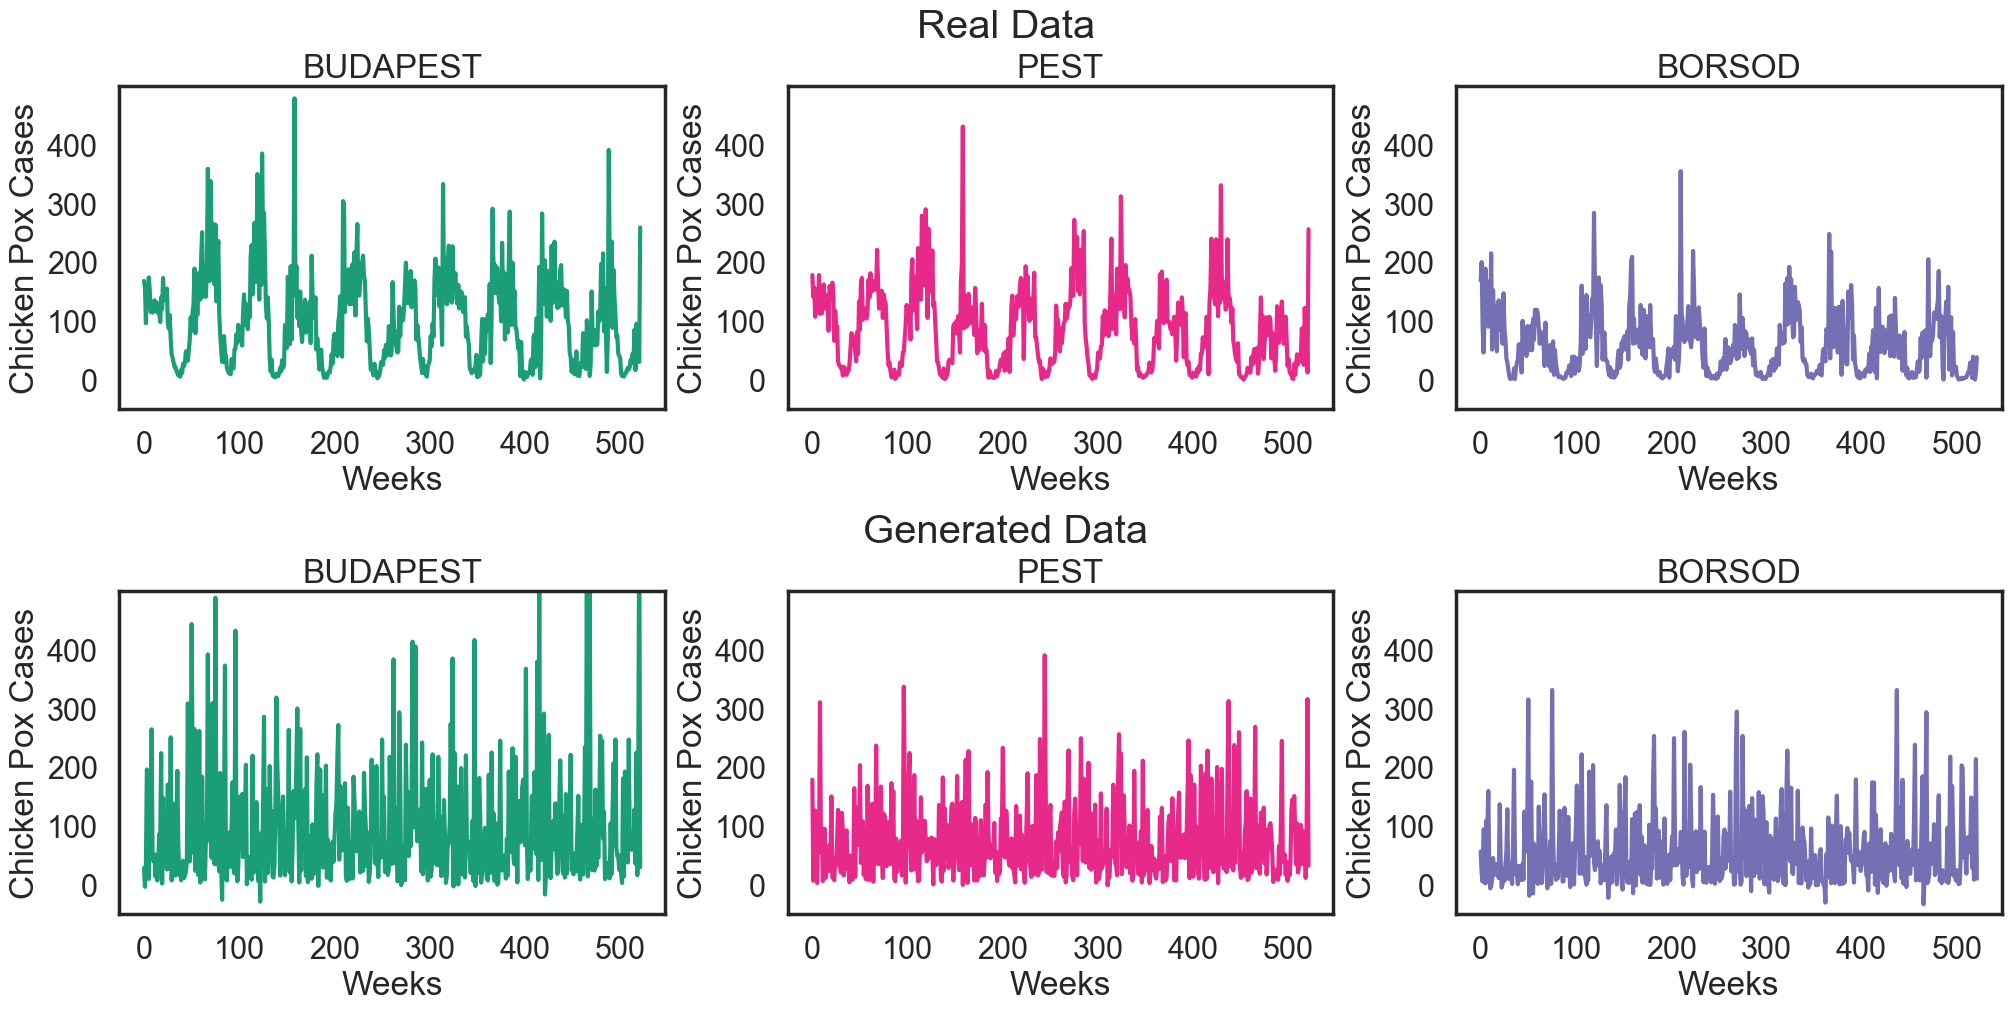

In [17]:
fig = plt.figure(constrained_layout=True, figsize=(20,10))
#fig.suptitle('Real vs. Generated Data')

df_list = [df, df_gen]
colors = ['#1b9e77','#e7298a', '#7570b3']
sub_titles = ['Real Data', 'Generated Data']
plot_titles = ['BUDAPEST', 'PEST', 'BORSOD']

# create 3x1 subfigs
subfigs = fig.subfigures(nrows=2, ncols=1)
for row, subfig in enumerate(subfigs):
    subfig.suptitle(sub_titles[row])

    # create 1x3 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=3)
    for col, ax in enumerate(axs):
        sns.lineplot(data=df_list[row],x=df.iloc[0:].index,y=plot_titles[col], ax=axs[col], color=colors[col], alpha=1)
        ax.set_title(plot_titles[col])
        ax.set_xticks(np.arange(0,550,100))
        ax.set_ylim(-50, 500)
        ax.set_yticks(np.arange(0,500,100))
        ax.set_xlabel('Weeks')
        ax.set_ylabel('Chicken Pox Cases')

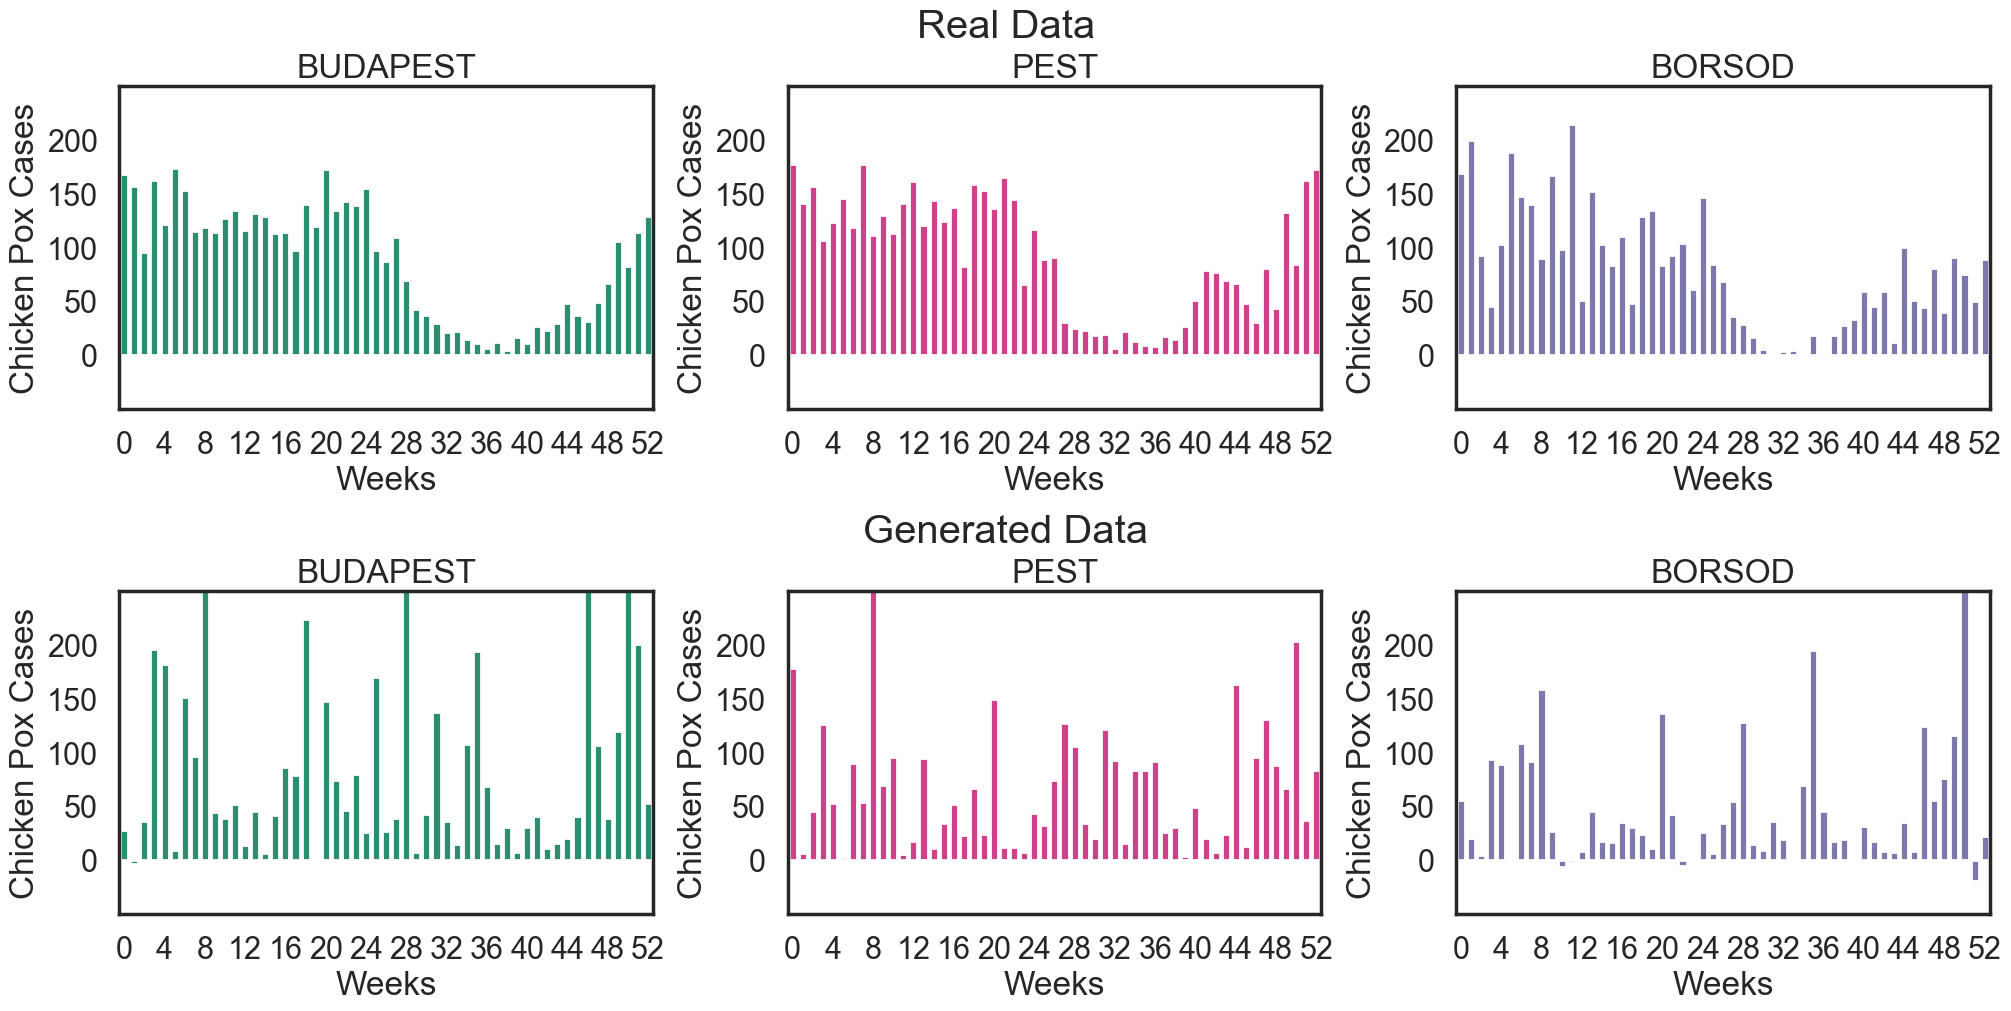

In [18]:
fig = plt.figure(constrained_layout=True, figsize=(20,10))
#fig.suptitle('Real vs. Generated Data')

df_list = [df.head(53), df_gen.head(53)]
colors = ['#1b9e77','#e7298a', '#7570b3']
sub_titles = ['Real Data', 'Generated Data']
plot_titles = ['BUDAPEST', 'PEST', 'BORSOD']

# create 3x1 subfigs
subfigs = fig.subfigures(nrows=2, ncols=1)
for row, subfig in enumerate(subfigs):
    subfig.suptitle(sub_titles[row])

    # create 1x3 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=3)
    for col, ax in enumerate(axs):
        sns.barplot(data=df_list[row],x=df.iloc[0:53].index,y=plot_titles[col], ax=axs[col], color=colors[col], alpha=1)
        ax.set_title(plot_titles[col])
        ax.set_xticks(np.arange(0,53,4))
        ax.set_ylim(-50, 250)
        ax.set_yticks(np.arange(0,250,50))
        ax.set_xlabel('Weeks')
        ax.set_ylabel('Chicken Pox Cases')


In [16]:
# sns.set_style('white')
# sns.set_context('talk')
# fig, axes = plt.subplots(1,3, figsize=(20,5))
# #fig.tight_layout()

# sns.lineplot(data=df_gen, x=df.index, y='BUDAPEST', ax=axes[0])
# axes[0].set_xlabel('Weeks')
# axes[0].set_ylabel('Chicken Pox Cases')
# axes[0].set_title('BUDAPEST')

# sns.lineplot(data=df_gen, x=df.index, y='PEST', ax=axes[1])
# axes[1].set_xlabel('Weeks')
# axes[1].set_ylabel('Chicken Pox Cases')
# axes[1].set_title('PEST')

# sns.lineplot(data=df_gen, x=df.index, y='BORSOD', ax=axes[2])
# axes[2].set_xlabel('Weeks')
# axes[2].set_ylabel('Chicken Pox Cases')
# axes[2].set_title('BORSOD')

In [17]:
# fig, axes = plt.subplots(1,3,figsize=(20,5))
# plt.subplots_adjust(left=0.1,
#                     bottom=0.1,
#                     right=0.9,
#                     top=0.9,
#                     wspace=0.3,
#                     hspace=0.3)

# sns.lineplot(data=df,x=df.index,y='BUDAPEST',ax=axes[0], color='#373c38', alpha=1, label='Real')
# sns.lineplot(data=df_gen,x=df.index,y='BUDAPEST',ax=axes[0], color='#1b9e77', alpha=0.75, label='Generated')
# axes[0].set_xticks(np.arange(0,550,100))
# axes[0].set_xlabel('Weeks')
# axes[0].set_ylabel('Chicken Pox Cases')
# axes[0].set_title('BUDAPEST')

# sns.lineplot(data=df,x=df.index,y='PEST',ax=axes[1], color='#373c38', label='Real')
# sns.lineplot(data=df_gen, x=df.index, y='PEST', ax=axes[1], color='#e7298a', alpha=0.75, label='Generated')
# axes[1].set_xticks(np.arange(0,550,100))
# axes[1].set_xlabel('Weeks')
# axes[1].set_ylabel('Chicken Pox Cases')
# axes[1].set_title('PEST')

# sns.lineplot(data=df,x=df.index,y='BORSOD',ax=axes[2], color='#373c38', label='Real')
# sns.lineplot(data=df_gen, x=df.index, y='BORSOD', ax=axes[2], color='#7570b3', alpha=0.75, label='Generated')
# axes[2].set_xticks(np.arange(0,550,100))
# axes[2].set_xlabel('Weeks')
# axes[2].set_ylabel('Chicken Pox Cases')
# axes[2].set_title('BORSOD');

In [18]:
# fig, axes = plt.subplots(2,3,figsize=(20,10))
# plt.subplots_adjust(left=0.1,
#                     bottom=0.1,
#                     right=0.9,
#                     top=0.9,
#                     wspace=0.3,
#                     hspace=0.3)

# subfigs = fig.subfigures

# sns.barplot(data=df,x=df.iloc[0:53].index,y=df['BUDAPEST'].head(53),ax=axes[0,0], color='#373c38', alpha=1, label='Real')
# axes[0,0].set_xticks(np.arange(0,53,4))
# axes[0,0].set_xlabel('Weeks')
# axes[0,0].set_ylabel('Chicken Pox Cases')
# axes[0,0].set_title('BUDAPEST')

# sns.barplot(data=df,x=df.iloc[0:53].index,y=df['PEST'].head(53),ax=axes[0,1], color='#373c38', label='Real')
# axes[0,1].set_xticks(np.arange(0,53,4))
# axes[0,1].set_xlabel('Weeks')
# axes[0,1].set_ylabel('Chicken Pox Cases')
# axes[0,1].set_title('PEST')

# sns.barplot(data=df,x=df.iloc[0:53].index,y=df['BORSOD'].head(53),ax=axes[0,2], color='#373c38', label='Real')
# axes[0,2].set_xticks(np.arange(0,53,4))
# axes[0,2].set_xlabel('Weeks')
# axes[0,2].set_ylabel('Chicken Pox Cases')
# axes[0,2].set_title('BORSOD')

# sns.barplot(data=df_gen,x=df.iloc[0:53].index,y=df_gen['BUDAPEST'].head(53),ax=axes[1,0], color='#1b9e77', alpha=0.75, label='Generated')
# axes[1,0].set_xticks(np.arange(0,53,4))
# axes[1,0].set_xlabel('Weeks')
# axes[1,0].set_ylabel('Chicken Pox Cases')

# sns.barplot(data=df_gen, x=df.iloc[0:53].index, y=df_gen['PEST'].head(53), ax=axes[1,1], color='#e7298a', alpha=0.75, label='Generated')
# axes[1,1].set_xticks(np.arange(0,53,4))
# axes[1,1].set_xlabel('Weeks')
# axes[1,1].set_ylabel('Chicken Pox Cases')

# sns.barplot(data=df_gen, x=df.iloc[0:53].index, y=df_gen['BUDAPEST'].head(53), ax=axes[1,2], color='#7570b3', alpha=0.75, label='Generated')
# axes[1,2].set_xticks(np.arange(0,53,4))
# axes[1,2].set_xlabel('Weeks')
# axes[1,2].set_ylabel('Chicken Pox Cases')

In [19]:
import dataloader

Text(0, 0.5, 'Generated values')

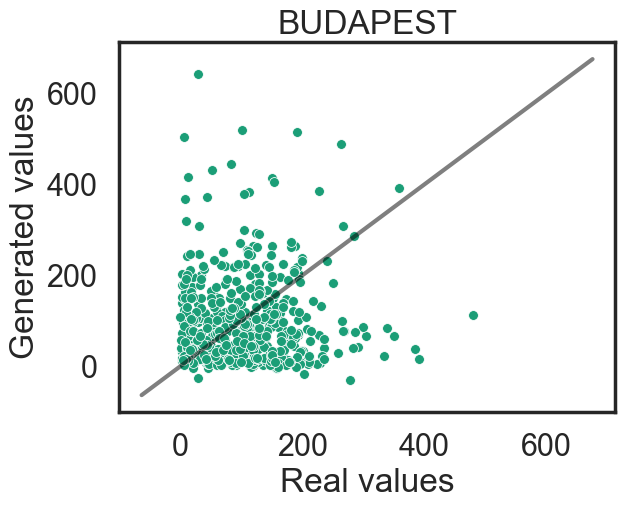

In [34]:
# parity plot of real vs. generated data

fig, ax = plt.subplots()
sns.scatterplot(x=df['BUDAPEST'], y=df_gen['BUDAPEST'], s=50, c='#1b9e77')
lims=ax.get_ylim() # get min and max to make a line
ax.plot(lims, lims, c='black', ls='-', alpha=0.5)
ax.set_title('BUDAPEST')
ax.set_xlabel('Real values')
ax.set_ylabel('Generated values')

In [35]:
import sklearn.metrics
from sklearn.metrics import r2_score

In [37]:
r2_score(df['BUDAPEST'], df_gen['BUDAPEST'])

-1.485129544549499